In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_metric
from lightgbm import plot_importance

%matplotlib inline

In [3]:
MDATA_PATH = '/home/chingisbadmaev/Desktop/sirius_university/machine_learning/task_4_preprocessing/mdata'

In [4]:
def get_dates():
    return sorted(os.listdir(MDATA_PATH))

def get_tickers(date):
    return sorted(os.listdir(os.path.join(MDATA_PATH,date)))

In [5]:
dates = get_dates()

date_tickers = dict([(date,get_tickers(date)) for date in dates])
tickers = np.unique(np.concatenate(list(date_tickers.values()))).tolist()

In [6]:
def get_market_data(ticker):
    data = []
    for date in tqdm(dates):
        #print (date)
        if not os.path.exists(os.path.join(MDATA_PATH,date,ticker)):
            continue
        df = pd.read_csv(
            os.path.join(MDATA_PATH,date,ticker),
            compression='gzip',
            dtype={'bar_time':float,'TIMESTAMP':float},
            index_col=0,
            parse_dates=[2,3],
            date_parser=pd.to_datetime,
        )
        df.drop([
                'TIMESTAMP','WEEKDAY','MINUTE','HOUR','ZERO_SPREAD_ON_TRADE','EMPTY_LOB_SIDE_AFTER_UPDATE','NEGATIVE_SPREAD_AFTER_UPDATE',
                'ZERO_SPREAD_AFTER_UPDATE','EMPTY_LOB_SIDE_ON_TRADE','NEGATIVE_SPREAD_ON_TRADE','bar_count','BAR_DURATION'
            ], axis = 1, inplace = True
        )
        df = df[df.columns[~df.columns.str.startswith('EXEC')]]
        data.append(df)
    data = pd.concat(data).set_index('bar_time').sort_index()
    
    price_grid = data.filter(like='PRICE_GRID')
    vol_grid = data.filter(like='VOL_GRID')
    
    data = data[ data.columns[ ~data.columns.str.startswith('PRICE_GRID') & ~data.columns.str.startswith('VOL_GRID') ] ]
    
    return data,price_grid,vol_grid

In [7]:
ticker = 'Z.BNB'

In [8]:
mdata,pgrid,vgrid = get_market_data(ticker)

100%|██████████| 292/292 [00:32<00:00,  8.93it/s]


In [9]:
returns_ahead = mdata['LAST'].pct_change().shift(-1).fillna(0)

In [10]:
returns_ahead = (returns_ahead > 0).values.astype(int)

In [11]:
# EXCLUDING NON-STATIONARY DATA HARD-CODED.
mdata.drop(['BEST_BID','BEST_ASK','LAST','HIGH','LOW','VWAP'],axis=1,inplace=True)

split data and targets

In [20]:
train_size = int(len(mdata) * 0.7)
val_size = int(len(mdata) * 0.9)

mdata_train = mdata.iloc[:train_size]
mdata_val = mdata.iloc[train_size:val_size]
mdata_test = mdata.iloc[val_size:]

returns_ahead_train = returns_ahead[:train_size]
returns_ahead_val = returns_ahead[train_size:val_size]
returns_ahead_test = returns_ahead[val_size:]

lightGBM

In [35]:
params = {
    'boosting_type': 'gbdt', # параметр по умолчанию
    'n_estimators': 500, # 500 деревьев
    #'learning_rate': 0.05665229811400253,
    'num_leaves': 3, # деревья из 3ех листьев
    #'reg_alpha': 12.490690707542772,
    #'reg_lambda': 82.913989266283,
    'subsample_freq': 0, # без положительного subsample_freq подвыборки браться не будут!
    'subsample': 1, # используем всю выборку
    'n_jobs': 4, # обучаемся на 4 ядрах
    'random_state': 23 # для воспроизводимости результата
}

boosting = LGBMClassifier(**params)

In [39]:
boosting.fit(
    X=mdata_train,
    y=returns_ahead_train,
    eval_set=[(mdata_train, returns_ahead_train), (mdata_val, returns_ahead_val)],
    eval_metric='auc', 
    callbacks=[lgb.early_stopping(stopping_rounds=100, first_metric_only=True),
              lgb.log_evaluation(50)]
)

Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.794838	training's binary_logloss: 0.412048	valid_1's auc: 0.508266	valid_1's binary_logloss: 0.69315
[100]	training's auc: 0.796911	training's binary_logloss: 0.411185	valid_1's auc: 0.51266	valid_1's binary_logloss: 0.693027
[150]	training's auc: 0.799764	training's binary_logloss: 0.410963	valid_1's auc: 0.514039	valid_1's binary_logloss: 0.692883
[200]	training's auc: 0.801382	training's binary_logloss: 0.410788	valid_1's auc: 0.514934	valid_1's binary_logloss: 0.692794
[250]	training's auc: 0.802638	training's binary_logloss: 0.410634	valid_1's auc: 0.515508	valid_1's binary_logloss: 0.692762
[300]	training's auc: 0.80368	training's binary_logloss: 0.410502	valid_1's auc: 0.515706	valid_1's binary_logloss: 0.69277
[350]	training's auc: 0.80471	training's binary_logloss: 0.410369	valid_1's auc: 0.515594	valid_1's binary_logloss: 0.692785
[400]	training's auc: 0.805473	training's binary_logloss: 0.41

LGBMClassifier(n_estimators=500, n_jobs=4, num_leaves=3, random_state=23,
               subsample=1)

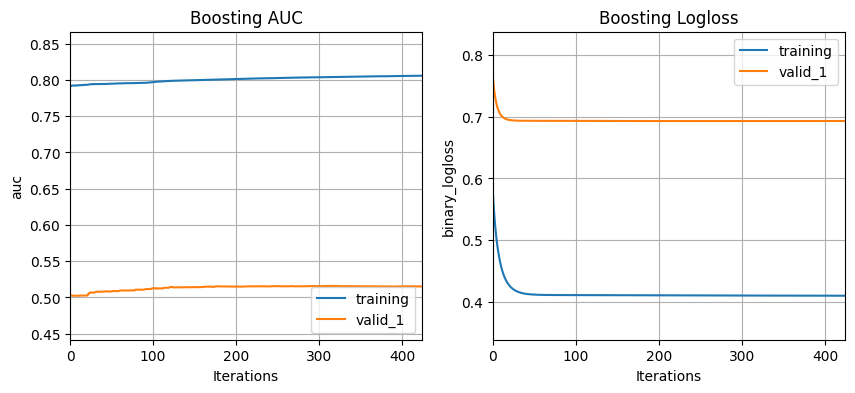

In [40]:
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

plot_metric(
    boosting,
    metric='auc',
    dataset_names=['training', 'valid_1'],
    ax=ax[0],
    title='Boosting AUC')
plot_metric(
    boosting,
    metric='binary_logloss',
    dataset_names=['training', 'valid_1'],
    ax=ax[1],
    title='Boosting Logloss')
plt.show()

In [47]:
y_pred = boosting.predict(mdata_test)
print('accuracy_score:', accuracy_score(returns_ahead_test, y_pred))

accuracy_score: 0.5111834166523014


Подбор гиперпараметров с помощью optuna

In [48]:
import optuna
def objective(trial):
    param = {
        'reg_lambda':trial.suggest_float('reg_lambda', 1e-1, 100, log=True), # Можем указать логшкалу
        'reg_alpha':trial.suggest_float('reg_alpha', 1e-1, 100, log=True),
        'num_leaves':trial.suggest_int('num_leaves', 3, 55), # Для целочисленных аналогично, но через функцию suggest_int
        'learning_rate':trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),        
        'n_estimators': 2000,
        'n_jobs': -1,
        'random_state': 4242
     }
     
    clf = LGBMClassifier(**param)
 
    clf.fit(mdata_train, returns_ahead_train,
            eval_set = [(mdata_train, returns_ahead_train), (mdata_val, returns_ahead_val)],
            eval_metric='auc',
            callbacks = [
                lgb.early_stopping(stopping_rounds=100, first_metric_only=True)
            ]
        )
    
    auc_val = clf.evals_result_['valid_1']['auc'][-1]
    auc_train = clf.evals_result_['training']['auc'][-1]
    
    # возвращаем метрики которые хотим оптимизировать
    return auc_val
 
study = optuna.create_study(direction='maximize') # Задаем направление в котором надо оптимизировать
study.optimize(objective, timeout=1000) # запускаем оптимизацию на 1000 секунд, можно задать n_trials чтобы ограничить число итераций


print(len(study.trials))
print('best trial')
trial = study.best_trial

print("Value: {}".format(trial.value))
print( 'Params: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')

/home/chingisbadmaev/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-09-28 01:55:17,232] A new study created in memory with name: no-name-d1e436f3-963f-4be1-8cb9-7ec3c5fddcce


Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:55:31,063] Trial 0 finished with value: 0.5158571619204112 and parameters: {'reg_lambda': 48.002030099987294, 'reg_alpha': 2.4701246031729185, 'num_leaves': 18, 'learning_rate': 0.03201190450042272}. Best is trial 0 with value: 0.5158571619204112.


Early stopping, best iteration is:
[205]	training's auc: 0.818085	training's binary_logloss: 0.40968	valid_1's auc: 0.516676	valid_1's binary_logloss: 0.69279
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:56:20,808] Trial 1 finished with value: 0.5165536478920391 and parameters: {'reg_lambda': 0.6766589422199847, 'reg_alpha': 0.1808841541890915, 'num_leaves': 7, 'learning_rate': 0.005105247879180745}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[1042]	training's auc: 0.804408	training's binary_logloss: 0.411194	valid_1's auc: 0.516613	valid_1's binary_logloss: 0.69285
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:56:30,558] Trial 2 finished with value: 0.5142958428679151 and parameters: {'reg_lambda': 39.55018318177926, 'reg_alpha': 1.4481336313279622, 'num_leaves': 16, 'learning_rate': 0.06780842324411632}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[111]	training's auc: 0.818318	training's binary_logloss: 0.409437	valid_1's auc: 0.515706	valid_1's binary_logloss: 0.692866
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:56:39,124] Trial 3 finished with value: 0.5144721755626407 and parameters: {'reg_lambda': 40.5668431251549, 'reg_alpha': 1.2350622463527183, 'num_leaves': 43, 'learning_rate': 0.020211044103024288}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[74]	training's auc: 0.811322	training's binary_logloss: 0.440961	valid_1's auc: 0.514612	valid_1's binary_logloss: 0.697846
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:56:51,351] Trial 4 finished with value: 0.5158642613536217 and parameters: {'reg_lambda': 69.54562763044345, 'reg_alpha': 2.9335306895778186, 'num_leaves': 26, 'learning_rate': 0.012055786959399023}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[192]	training's auc: 0.809449	training's binary_logloss: 0.423259	valid_1's auc: 0.51606	valid_1's binary_logloss: 0.694076
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:57:02,525] Trial 5 finished with value: 0.5137218655329694 and parameters: {'reg_lambda': 0.17600611504044325, 'reg_alpha': 71.12017981953993, 'num_leaves': 37, 'learning_rate': 0.068375532041822}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[127]	training's auc: 0.816982	training's binary_logloss: 0.409501	valid_1's auc: 0.51423	valid_1's binary_logloss: 0.69293
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:57:35,605] Trial 6 finished with value: 0.5162274194174805 and parameters: {'reg_lambda': 43.79208848594636, 'reg_alpha': 0.12397477523250372, 'num_leaves': 50, 'learning_rate': 0.008331074767995602}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[501]	training's auc: 0.8323	training's binary_logloss: 0.410143	valid_1's auc: 0.516679	valid_1's binary_logloss: 0.692866
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:57:57,042] Trial 7 finished with value: 0.5151780372899981 and parameters: {'reg_lambda': 0.10367284882241044, 'reg_alpha': 4.4053055233231095, 'num_leaves': 20, 'learning_rate': 0.005624764849257149}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[393]	training's auc: 0.812163	training's binary_logloss: 0.424284	valid_1's auc: 0.515483	valid_1's binary_logloss: 0.694284
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:58:11,359] Trial 8 finished with value: 0.51436647503142 and parameters: {'reg_lambda': 0.852649557267768, 'reg_alpha': 1.5133328806960835, 'num_leaves': 44, 'learning_rate': 0.024535775310078164}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[175]	training's auc: 0.842844	training's binary_logloss: 0.408581	valid_1's auc: 0.515588	valid_1's binary_logloss: 0.692976
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:58:27,590] Trial 9 finished with value: 0.5158112688904037 and parameters: {'reg_lambda': 1.111710673620821, 'reg_alpha': 0.23118562185341227, 'num_leaves': 25, 'learning_rate': 0.006257819734883918}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[260]	training's auc: 0.81295	training's binary_logloss: 0.436398	valid_1's auc: 0.516122	valid_1's binary_logloss: 0.696635
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:58:32,613] Trial 10 finished with value: 0.5063440238005503 and parameters: {'reg_lambda': 5.877582784297332, 'reg_alpha': 0.3138925742259583, 'num_leaves': 6, 'learning_rate': 0.001713991087704667}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[54]	training's auc: 0.792908	training's binary_logloss: 0.583037	valid_1's auc: 0.506767	valid_1's binary_logloss: 0.768471
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:58:51,257] Trial 11 finished with value: 0.5150001895232931 and parameters: {'reg_lambda': 6.387132943281998, 'reg_alpha': 0.12582204910349046, 'num_leaves': 54, 'learning_rate': 0.0033894693810495938}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[276]	training's auc: 0.821258	training's binary_logloss: 0.467852	valid_1's auc: 0.51509	valid_1's binary_logloss: 0.707224
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:58:55,649] Trial 12 finished with value: 0.5025101186018358 and parameters: {'reg_lambda': 13.553454031852779, 'reg_alpha': 0.13558326233342388, 'num_leaves': 3, 'learning_rate': 0.002433449579921865}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[44]	training's auc: 0.791676	training's binary_logloss: 0.579543	valid_1's auc: 0.502923	valid_1's binary_logloss: 0.765995
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:59:31,534] Trial 13 finished with value: 0.514858827457193 and parameters: {'reg_lambda': 2.0081862913149346, 'reg_alpha': 0.4795836064813055, 'num_leaves': 54, 'learning_rate': 0.0011328479586368225}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[593]	training's auc: 0.81799	training's binary_logloss: 0.489933	valid_1's auc: 0.514916	valid_1's binary_logloss: 0.71667
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 01:59:51,860] Trial 14 finished with value: 0.5149779198689016 and parameters: {'reg_lambda': 0.40513942572725564, 'reg_alpha': 0.10472300486017476, 'num_leaves': 35, 'learning_rate': 0.008613104859413365}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[337]	training's auc: 0.827907	training's binary_logloss: 0.415513	valid_1's auc: 0.515497	valid_1's binary_logloss: 0.693299
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:00:17,698] Trial 15 finished with value: 0.5157263456932121 and parameters: {'reg_lambda': 12.917464462841126, 'reg_alpha': 0.4951508151366643, 'num_leaves': 11, 'learning_rate': 0.003582771631859076}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[542]	training's auc: 0.803591	training's binary_logloss: 0.429501	valid_1's auc: 0.515901	valid_1's binary_logloss: 0.695073
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:00:28,536] Trial 16 finished with value: 0.5158216849522227 and parameters: {'reg_lambda': 2.3897411553780743, 'reg_alpha': 0.20942268836854322, 'num_leaves': 32, 'learning_rate': 0.012159218314990318}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[108]	training's auc: 0.8155	training's binary_logloss: 0.447297	valid_1's auc: 0.515934	valid_1's binary_logloss: 0.699688
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:00:52,673] Trial 17 finished with value: 0.5161254025588154 and parameters: {'reg_lambda': 99.65339715547103, 'reg_alpha': 0.10649669793761413, 'num_leaves': 45, 'learning_rate': 0.005279128344787726}. Best is trial 1 with value: 0.5165536478920391.


Early stopping, best iteration is:
[448]	training's auc: 0.815787	training's binary_logloss: 0.422305	valid_1's auc: 0.516135	valid_1's binary_logloss: 0.694016
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:01:17,438] Trial 18 finished with value: 0.5166021257843542 and parameters: {'reg_lambda': 0.4256605479844049, 'reg_alpha': 0.5626318685933469, 'num_leaves': 12, 'learning_rate': 0.008617558213073863}. Best is trial 18 with value: 0.5166021257843542.


Early stopping, best iteration is:
[481]	training's auc: 0.81023	training's binary_logloss: 0.412085	valid_1's auc: 0.516762	valid_1's binary_logloss: 0.692871
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:01:42,149] Trial 19 finished with value: 0.5156089568668828 and parameters: {'reg_lambda': 0.42102278694017276, 'reg_alpha': 0.6244908644040207, 'num_leaves': 11, 'learning_rate': 0.003430020356893136}. Best is trial 18 with value: 0.5166021257843542.


Early stopping, best iteration is:
[522]	training's auc: 0.80382	training's binary_logloss: 0.432743	valid_1's auc: 0.515627	valid_1's binary_logloss: 0.695686
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:02:10,301] Trial 20 finished with value: 0.5167829424049473 and parameters: {'reg_lambda': 0.34389622232252653, 'reg_alpha': 0.792308393824651, 'num_leaves': 14, 'learning_rate': 0.014079858274221329}. Best is trial 20 with value: 0.5167829424049473.


Early stopping, best iteration is:
[509]	training's auc: 0.818757	training's binary_logloss: 0.409269	valid_1's auc: 0.517104	valid_1's binary_logloss: 0.692826
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:02:24,738] Trial 21 finished with value: 0.5165598082406408 and parameters: {'reg_lambda': 0.33861394853210397, 'reg_alpha': 0.5993139405353721, 'num_leaves': 10, 'learning_rate': 0.016438230889630135}. Best is trial 20 with value: 0.5167829424049473.


Early stopping, best iteration is:
[227]	training's auc: 0.806758	training's binary_logloss: 0.413376	valid_1's auc: 0.516743	valid_1's binary_logloss: 0.69294
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:02:41,523] Trial 22 finished with value: 0.51640036583579 and parameters: {'reg_lambda': 0.264600299401165, 'reg_alpha': 0.6620953549790243, 'num_leaves': 12, 'learning_rate': 0.018773355625290894}. Best is trial 20 with value: 0.5167829424049473.


Early stopping, best iteration is:
[227]	training's auc: 0.810535	training's binary_logloss: 0.411832	valid_1's auc: 0.516892	valid_1's binary_logloss: 0.69288
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:02:59,131] Trial 23 finished with value: 0.5169475166924379 and parameters: {'reg_lambda': 0.2022339262305108, 'reg_alpha': 0.9315351785009054, 'num_leaves': 21, 'learning_rate': 0.013662759690844429}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[240]	training's auc: 0.817576	training's binary_logloss: 0.414207	valid_1's auc: 0.517183	valid_1's binary_logloss: 0.693036
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:03:12,547] Trial 24 finished with value: 0.5164901214300475 and parameters: {'reg_lambda': 0.14494791224392248, 'reg_alpha': 0.9091997180399846, 'num_leaves': 21, 'learning_rate': 0.013681948383087322}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[208]	training's auc: 0.815802	training's binary_logloss: 0.416975	valid_1's auc: 0.516669	valid_1's binary_logloss: 0.693257
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:03:29,850] Trial 25 finished with value: 0.5165728574539142 and parameters: {'reg_lambda': 0.20055127430246913, 'reg_alpha': 0.41035749096257956, 'num_leaves': 15, 'learning_rate': 0.009722067204930136}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[373]	training's auc: 0.813024	training's binary_logloss: 0.413222	valid_1's auc: 0.516777	valid_1's binary_logloss: 0.692959
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:03:40,888] Trial 26 finished with value: 0.5159011152589709 and parameters: {'reg_lambda': 0.567275173884137, 'reg_alpha': 0.2878382039314844, 'num_leaves': 24, 'learning_rate': 0.028400588731230712}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[100]	training's auc: 0.817664	training's binary_logloss: 0.41678	valid_1's auc: 0.516712	valid_1's binary_logloss: 0.693278
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:03:57,216] Trial 27 finished with value: 0.5157392572359852 and parameters: {'reg_lambda': 0.24687266310780037, 'reg_alpha': 0.9322013073913221, 'num_leaves': 29, 'learning_rate': 0.009064964781938446}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[172]	training's auc: 0.815509	training's binary_logloss: 0.438275	valid_1's auc: 0.516292	valid_1's binary_logloss: 0.697135
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:04:09,606] Trial 28 finished with value: 0.5157345741173874 and parameters: {'reg_lambda': 0.11728332821289654, 'reg_alpha': 4.804121150036243, 'num_leaves': 14, 'learning_rate': 0.015121218474073505}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[161]	training's auc: 0.807779	training's binary_logloss: 0.421568	valid_1's auc: 0.516522	valid_1's binary_logloss: 0.693802
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:04:18,482] Trial 29 finished with value: 0.5162410130444517 and parameters: {'reg_lambda': 0.20578651775510856, 'reg_alpha': 2.173388414161823, 'num_leaves': 19, 'learning_rate': 0.03126078090699633}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[82]	training's auc: 0.812541	training's binary_logloss: 0.419688	valid_1's auc: 0.517087	valid_1's binary_logloss: 0.693517
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:04:26,381] Trial 30 finished with value: 0.5147528409056416 and parameters: {'reg_lambda': 1.144989175415464, 'reg_alpha': 0.34116216087355267, 'num_leaves': 22, 'learning_rate': 0.05373277691976333}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[63]	training's auc: 0.817312	training's binary_logloss: 0.413571	valid_1's auc: 0.515925	valid_1's binary_logloss: 0.693063
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:04:48,769] Trial 31 finished with value: 0.5169058733395042 and parameters: {'reg_lambda': 0.179254043010548, 'reg_alpha': 0.35577989243959884, 'num_leaves': 16, 'learning_rate': 0.01025724444251392}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[291]	training's auc: 0.811755	training's binary_logloss: 0.416343	valid_1's auc: 0.517052	valid_1's binary_logloss: 0.693163
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:05:02,090] Trial 32 finished with value: 0.5162287285641082 and parameters: {'reg_lambda': 0.5063200258571258, 'reg_alpha': 0.8040899678478665, 'num_leaves': 7, 'learning_rate': 0.021368197955828474}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[164]	training's auc: 0.802217	training's binary_logloss: 0.414469	valid_1's auc: 0.51668	valid_1's binary_logloss: 0.692994
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:05:18,370] Trial 33 finished with value: 0.5152559731869498 and parameters: {'reg_lambda': 0.28459785809205546, 'reg_alpha': 0.36089265309492835, 'num_leaves': 17, 'learning_rate': 0.007059762223279422}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[211]	training's auc: 0.80716	training's binary_logloss: 0.441117	valid_1's auc: 0.515547	valid_1's binary_logloss: 0.697725
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:05:40,047] Trial 34 finished with value: 0.5160989217658039 and parameters: {'reg_lambda': 0.10186570256994333, 'reg_alpha': 0.2189600587970157, 'num_leaves': 16, 'learning_rate': 0.011305405481903437}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[345]	training's auc: 0.814435	training's binary_logloss: 0.412251	valid_1's auc: 0.516593	valid_1's binary_logloss: 0.692911
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:05:55,118] Trial 35 finished with value: 0.5166962631543611 and parameters: {'reg_lambda': 0.15198721354222736, 'reg_alpha': 1.3410419790917423, 'num_leaves': 7, 'learning_rate': 0.016622808563717135}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[246]	training's auc: 0.803096	training's binary_logloss: 0.412769	valid_1's auc: 0.516962	valid_1's binary_logloss: 0.692875
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:06:57,768] Trial 36 finished with value: 0.5162141294549515 and parameters: {'reg_lambda': 0.1669954287752901, 'reg_alpha': 1.2476051377530473, 'num_leaves': 3, 'learning_rate': 0.014892189372737284}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[1485]	training's auc: 0.801839	training's binary_logloss: 0.410744	valid_1's auc: 0.516257	valid_1's binary_logloss: 0.692772
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:07:10,746] Trial 37 finished with value: 0.5165595133982545 and parameters: {'reg_lambda': 0.15610746254008617, 'reg_alpha': 1.9270062719762175, 'num_leaves': 7, 'learning_rate': 0.01896175687775206}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[194]	training's auc: 0.802638	training's binary_logloss: 0.413864	valid_1's auc: 0.517163	valid_1's binary_logloss: 0.692921
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:07:18,798] Trial 38 finished with value: 0.5160714259720729 and parameters: {'reg_lambda': 0.2920904050600466, 'reg_alpha': 0.9598562243675408, 'num_leaves': 28, 'learning_rate': 0.04072826210456818}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[44]	training's auc: 0.81484	training's binary_logloss: 0.431613	valid_1's auc: 0.516758	valid_1's binary_logloss: 0.695468
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:07:35,314] Trial 39 finished with value: 0.5163793036422267 and parameters: {'reg_lambda': 0.1414298762285625, 'reg_alpha': 1.7228504113701781, 'num_leaves': 18, 'learning_rate': 0.023898003257434863}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[240]	training's auc: 0.821698	training's binary_logloss: 0.409394	valid_1's auc: 0.516779	valid_1's binary_logloss: 0.692797
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:07:56,451] Trial 40 finished with value: 0.5162598077375515 and parameters: {'reg_lambda': 0.21313046546087366, 'reg_alpha': 3.0795706366021407, 'num_leaves': 9, 'learning_rate': 0.011544200238339528}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[353]	training's auc: 0.806034	training's binary_logloss: 0.412603	valid_1's auc: 0.516464	valid_1's binary_logloss: 0.692897
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:08:21,831] Trial 41 finished with value: 0.5167429401865253 and parameters: {'reg_lambda': 0.3871121550317955, 'reg_alpha': 1.204298124042017, 'num_leaves': 15, 'learning_rate': 0.007800534600712281}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[466]	training's auc: 0.812368	training's binary_logloss: 0.413238	valid_1's auc: 0.516787	valid_1's binary_logloss: 0.692922
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:08:56,044] Trial 42 finished with value: 0.516715690249556 and parameters: {'reg_lambda': 0.6715897397054521, 'reg_alpha': 1.2066209657477474, 'num_leaves': 14, 'learning_rate': 0.006682961246675385}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[600]	training's auc: 0.81227	training's binary_logloss: 0.412214	valid_1's auc: 0.516836	valid_1's binary_logloss: 0.692882
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:09:25,142] Trial 43 finished with value: 0.5168651955373464 and parameters: {'reg_lambda': 0.6851954118588495, 'reg_alpha': 1.2794287296707099, 'num_leaves': 14, 'learning_rate': 0.006795868926175237}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[463]	training's auc: 0.810221	training's binary_logloss: 0.415539	valid_1's auc: 0.517064	valid_1's binary_logloss: 0.693094
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:09:46,155] Trial 44 finished with value: 0.5163057892202749 and parameters: {'reg_lambda': 0.7774910271650495, 'reg_alpha': 2.4256980163270367, 'num_leaves': 22, 'learning_rate': 0.007340512973420404}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[264]	training's auc: 0.813039	training's binary_logloss: 0.428921	valid_1's auc: 0.516618	valid_1's binary_logloss: 0.695051
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:09:58,297] Trial 45 finished with value: 0.5163439891855899 and parameters: {'reg_lambda': 0.35024523987062683, 'reg_alpha': 0.7425525717066167, 'num_leaves': 19, 'learning_rate': 0.010607794632829131}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[136]	training's auc: 0.808275	training's binary_logloss: 0.442671	valid_1's auc: 0.516618	valid_1's binary_logloss: 0.6981
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:10:18,456] Trial 46 finished with value: 0.5155820971897966 and parameters: {'reg_lambda': 0.5275350262576352, 'reg_alpha': 1.6122082679035636, 'num_leaves': 23, 'learning_rate': 0.004696365705276644}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[298]	training's auc: 0.810618	training's binary_logloss: 0.444221	valid_1's auc: 0.515812	valid_1's binary_logloss: 0.698694
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:10:34,275] Trial 47 finished with value: 0.5164063841028638 and parameters: {'reg_lambda': 0.9904149914406187, 'reg_alpha': 0.4242243885568806, 'num_leaves': 15, 'learning_rate': 0.01268698410312461}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[235]	training's auc: 0.810763	training's binary_logloss: 0.416456	valid_1's auc: 0.516663	valid_1's binary_logloss: 0.693189
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:10:50,673] Trial 48 finished with value: 0.5144303070151285 and parameters: {'reg_lambda': 0.24132290127788875, 'reg_alpha': 3.7969440283392455, 'num_leaves': 27, 'learning_rate': 0.009874910286631315}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[236]	training's auc: 0.817184	training's binary_logloss: 0.422157	valid_1's auc: 0.515288	valid_1's binary_logloss: 0.69406
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:11:06,988] Trial 49 finished with value: 0.516295412625547 and parameters: {'reg_lambda': 0.3396368396168962, 'reg_alpha': 1.0307476472472878, 'num_leaves': 25, 'learning_rate': 0.007454984127682828}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[218]	training's auc: 0.81305	training's binary_logloss: 0.436457	valid_1's auc: 0.516489	valid_1's binary_logloss: 0.696661
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:11:25,836] Trial 50 finished with value: 0.5154351437976847 and parameters: {'reg_lambda': 0.6879092335362545, 'reg_alpha': 0.1656106810340155, 'num_leaves': 31, 'learning_rate': 0.0052620321762915}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[271]	training's auc: 0.815862	training's binary_logloss: 0.442824	valid_1's auc: 0.51566	valid_1's binary_logloss: 0.698368
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:11:55,485] Trial 51 finished with value: 0.5167784742659163 and parameters: {'reg_lambda': 0.6941066143759809, 'reg_alpha': 1.1977669915132323, 'num_leaves': 13, 'learning_rate': 0.006066151984103918}. Best is trial 23 with value: 0.5169475166924379.


Early stopping, best iteration is:
[484]	training's auc: 0.808238	training's binary_logloss: 0.416961	valid_1's auc: 0.516822	valid_1's binary_logloss: 0.693198
Evaluated only: auc
Training until validation scores don't improve for 100 rounds


[I 2023-09-28 02:12:20,134] Trial 52 finished with value: 0.5170136349815179 and parameters: {'reg_lambda': 0.42323999396093775, 'reg_alpha': 0.7762279101310304, 'num_leaves': 13, 'learning_rate': 0.0078106917077734725}. Best is trial 52 with value: 0.5170136349815179.


Early stopping, best iteration is:
[441]	training's auc: 0.809644	training's binary_logloss: 0.414145	valid_1's auc: 0.517159	valid_1's binary_logloss: 0.692978
Evaluated only: auc
53
best trial
Value: 0.5170136349815179
Params: 
reg_lambda: 0.42323999396093775
reg_alpha: 0.7762279101310304
num_leaves: 13
learning_rate: 0.0078106917077734725


In [49]:
best_optuna_params = trial.params

best_optuna_boosting = LGBMClassifier(**best_optuna_params)

In [50]:
best_optuna_boosting.fit(
    mdata_train, returns_ahead_train,
    eval_set = [(mdata_train, returns_ahead_train), (mdata_val, returns_ahead_val)],
    eval_metric='auc',
    callbacks = [
        lgb.early_stopping(stopping_rounds=1000, first_metric_only=True),
        lgb.log_evaluation(1000)
    ]
)

Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.801281	training's binary_logloss: 0.480572	valid_1's auc: 0.513211	valid_1's binary_logloss: 0.711629
Evaluated only: auc


LGBMClassifier(learning_rate=0.0078106917077734725, num_leaves=13,
               reg_alpha=0.7762279101310304, reg_lambda=0.42323999396093775)

In [62]:
y_pred = best_optuna_boosting.predict(mdata_test)
print('accuracy_score:', accuracy_score(returns_ahead_test, y_pred))

accuracy_score: 0.5000215480089639


из списка результата оптуны руками выбераем паарметры

Training until validation scores don't improve for 300 rounds
[50]	training's auc: 0.799043	training's binary_logloss: 0.525255	valid_1's auc: 0.511717	valid_1's binary_logloss: 0.733568
[100]	training's auc: 0.800953	training's binary_logloss: 0.480575	valid_1's auc: 0.51272	valid_1's binary_logloss: 0.711589
[150]	training's auc: 0.802822	training's binary_logloss: 0.454655	valid_1's auc: 0.514444	valid_1's binary_logloss: 0.70168
[200]	training's auc: 0.804142	training's binary_logloss: 0.438922	valid_1's auc: 0.514989	valid_1's binary_logloss: 0.69711
[250]	training's auc: 0.805252	training's binary_logloss: 0.429048	valid_1's auc: 0.515261	valid_1's binary_logloss: 0.69495
[300]	training's auc: 0.806355	training's binary_logloss: 0.422694	valid_1's auc: 0.515823	valid_1's binary_logloss: 0.693904
[350]	training's auc: 0.807297	training's binary_logloss: 0.418525	valid_1's auc: 0.5162	valid_1's binary_logloss: 0.693381
[400]	training's auc: 0.808388	training's binary_logloss: 0.415

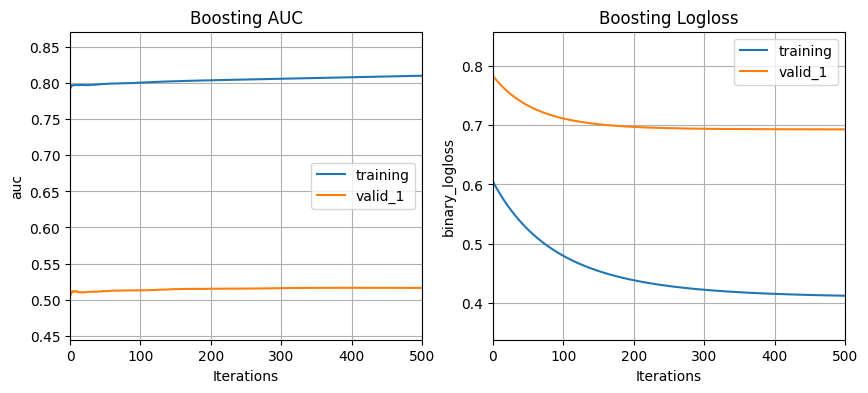

accuracy_score: 0.5065721427340114


In [66]:
params = {
    'boosting_type': 'gbdt', # параметр по умолчанию
    'n_estimators': 500, # 500 деревьев
    'learning_rate': 0.0078106917077734725,
    'num_leaves': 13, # деревья из 13 листьев
    'reg_alpha': 0.7762279101310304,
    'reg_lambda': 0.42323999396093775,
    'subsample_freq': 0, # без положительного subsample_freq подвыборки браться не будут!
    'subsample': 1, # используем всю выборку
    'n_jobs': -1, # обучаемся на 4 ядрах
    'random_state': 23 # для воспроизводимости результата
}

boosting = LGBMClassifier(**params)

boosting.fit(
    X=mdata_train,
    y=returns_ahead_train,
    eval_set=[(mdata_train, returns_ahead_train), (mdata_val, returns_ahead_val)],
    eval_metric='auc', 
    callbacks=[lgb.early_stopping(stopping_rounds=300, first_metric_only=True),
              lgb.log_evaluation(50)]
)

fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

plot_metric(
    boosting,
    metric='auc',
    dataset_names=['training', 'valid_1'],
    ax=ax[0],
    title='Boosting AUC')
plot_metric(
    boosting,
    metric='binary_logloss',
    dataset_names=['training', 'valid_1'],
    ax=ax[1],
    title='Boosting Logloss')
plt.show()

y_pred = boosting.predict(mdata_test)
print('accuracy_score:', accuracy_score(returns_ahead_test, y_pred))

In [149]:
position = pd.DataFrame(boosting.predict_proba(mdata_test))

In [150]:
long_pos = position.loc[position[1] > position[1].quantile(0.99)].index
short_pos = position.loc[position[1] < position[1].quantile(0.01)].index

long-short strategy

In [151]:
position.loc[position[1] > position[1].quantile(0.99)] = 1
position.loc[position[1] < position[1].quantile(0.01)] = -1
position.loc[(position[1] > position[1].quantile(0.01)) & (position[1] < position[1].quantile(0.99))] = 0

In [152]:
position.value_counts()

0     1   
 0.0   0.0    45478
-1.0  -1.0      465
 1.0   1.0      465
dtype: int64

In [133]:
returns = get_market_data(ticker)[0]['LAST'].pct_change().shift(-1).fillna(0)
returns_test = returns.iloc[val_size:]

100%|██████████| 292/292 [00:36<00:00,  8.00it/s]


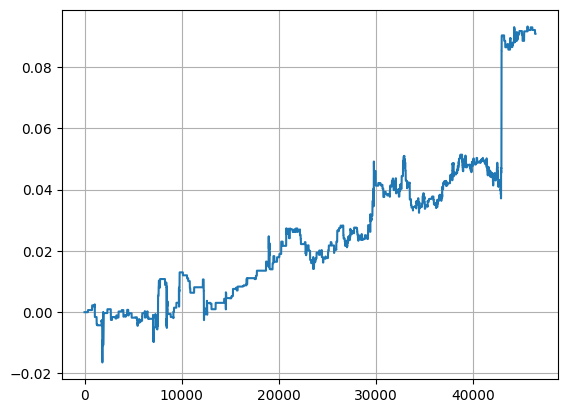

In [153]:
strategy_1 = np.asarray(position[1])
pnl = (np.asarray(returns_test) * strategy_1)
plt.plot(pnl.cumsum())
plt.grid()

only long strategy

In [154]:
position.loc[position[1] < position[1].quantile(0.99)] = 0

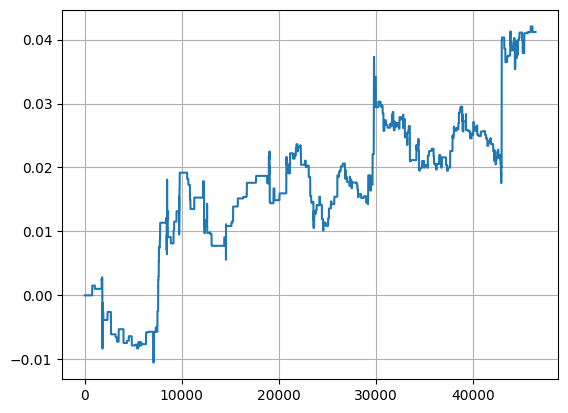

In [173]:
strategy_1 = np.asarray(position[1])
pnl = (np.asarray(returns_test) * strategy_1)
plt.plot(pnl.cumsum())
plt.grid()